In [92]:
import os
import glob
import unicodedata
import string
import pretty_errors
from rich.progress import track

## 1. 加载数据

In [14]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

findfiles = lambda p: glob.glob(p)


def unicodeToAscii(s):
    """将unicode编码转为ascii编码"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


category_lines = {}
all_categories = []
for filename in findfiles('./data/genrate_name/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
    
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


## 2. 构建模型

模型结构如下
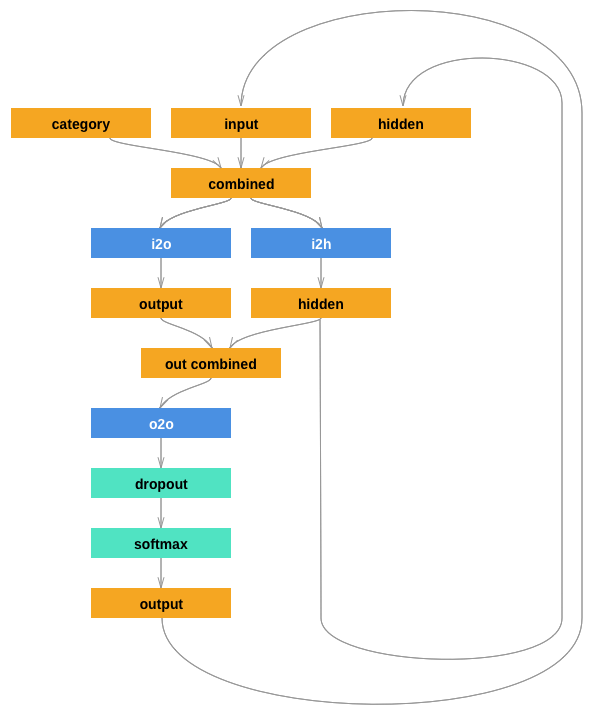

In [16]:
import torch
import torch.nn as nn

In [138]:
# 1.上图中将类别、输入大小，隐层曾大小组合起来，作为i2o和i2h的输入层
# 2. i2h的输出为隐藏层
# 3. i2o的输出为输出层
# 4. 将上两个输出组合起来为o2o的输入
# 5. 带有nn.dropout的神经网络能有效防止过拟合，nn.dropout(0.1)表示每次迭代训练时有10%的概率失活，不进行训练

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        # 4.将上两个输出组合起来为o2o的输入
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        outout_combined = torch.cat((hidden, output), 1)
        output = self.o2o(outout_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 3. 训练模型辅助函数

In [93]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    """随机获取一个类别中的一个名称"""
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [119]:
# 对类别进行one-hot编码
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# 对输入词语从第一个字母到最后一个字母进行编码，不包括<EOS>进行one-hot编码
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


# 对输入的单词的标签
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)   # 添加EOS
    return torch.LongTensor(letter_indexes)


# 根据类别、标签、输入随机生成样本张量
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## 4. 训练神经网络

In [139]:
criterion = nn.NLLLoss()   # 损失函数

learning_rate = 0.0005    # 学习率


# def train(category_tensor, input_line_tensor, target_line_tensor):
#     target_line_tensor.unsqueeze_(-1)
#     hidden = rnn.initHidden()

#     rnn.zero_grad()

#     loss = 0

#     for i in range(input_line_tensor.size(0)):
#         output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
#         l = criterion(output, target_line_tensor[i])
#         loss += l

#     loss.backward()

#     for p in rnn.parameters():
#         p.data.add_(p.grad.data, alpha=-learning_rate)

#     return output, loss.item() / input_line_tensor.size(0)


def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)   # 更改tensor的维度
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)


import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [140]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in track(range(1, n_iters + 1)):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

## 5. 绘制损失曲线

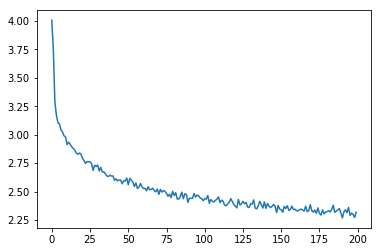

In [141]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 6. 使用模型生成名称

In [149]:
max_length = 20    # 名字的最大长度

def sample(category, start_letter='A'):
    # with计算图计算
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            # 当字母为EOS时结束
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name


# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [164]:
sample('English', 'l')

'londer'

In [165]:
# 存储模型
torch.save(rnn.state_dict(), './data/model/4_genrate_name_paramster.pkl')

In [ ]:
# 测试nn.Linear
m = nn.Linear(20, 1)
input = torch.randn(128, 20)
print(input)
m(input)


In [48]:
# 测试torch.cat
# 拼接tensor，以第二个参数进行不同方式的拼接
a = torch.tensor([[18, 20]])
b = torch.tensor([[200, 14]])
torch.cat((a, b), 0)

tensor([[ 18,  20],
        [200,  14]])

In [59]:
sum(filter(lambda x: x % 3 == 0 or x % 5 == 0, range(10)))

23

In [79]:
from rich.console import Console
from rich.table import Column, Table

console = Console()

table = Table(show_header=True, header_style="bold magenta")
table.add_column("Date", style="dim", width=12)
table.add_column("Title")
table.add_column("Production Budget", justify="right")
table.add_column("Box Office", justify="right")
table.add_row(
    "Dev 20, 2019", "Star Wars: The Rise of Skywalker", "$275,000,000", "$375,126,118"
)
table.add_row(
    "May 25, 2018",
    "[red]Solo[/red]: A Star Wars Story",
    "$275,000,000",
    "$393,151,347",
)
table.add_row(
    "Dec 15, 2017",
    "Star Wars Ep. VIII: The Last Jedi",
    "$262,000,000",
    "[bold]$1,332,539,889[/bold]",
)

console.print(table)

1
